In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import Pool, cv
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    MAPE
    """
    y_true, y_pred = np.array(y_true).reshape(-1), np.array(y_pred).reshape(-1)

    return np.sum(np.abs(y_true - y_pred))/np.sum(y_true)/y_true.shape[0]*100

os.environ['NUMEXPR_MAX_THREADS'] = '16'
pd.set_option('display.max_columns', 1500)
pd.set_option('display.max_rows', 500)

# Load & split datasets

In [2]:
X_train_val = pd.read_pickle('Train_sample/X_train_val.pkl')
y_train_val = pd.read_pickle('Train_sample/y_train_val.pkl')
id_train_val = pd.read_pickle('Train_sample/id_train_val.pkl')
id_train_val['billing_record_msk_date'] = pd.to_datetime(id_train_val['billing_record_msk_date'])

X_test = pd.read_pickle('Train_sample/X_test.pkl')
y_test = pd.read_pickle('Train_sample/y_test.pkl')
id_test = pd.read_pickle('Train_sample/id_test.pkl')
id_test['billing_record_msk_date'] = pd.to_datetime(id_test['billing_record_msk_date'])

X_oot = pd.read_pickle('Train_sample/X_oot.pkl')
y_oot = pd.read_pickle('Train_sample/y_oot.pkl')
id_oot = pd.read_pickle('Train_sample/id_oot.pkl')
id_oot['billing_record_msk_date'] = pd.to_datetime(id_oot['billing_record_msk_date'])

# y_train_val = y_train_val - X_train_val['prev_7d_cons'].fillna(0)
# y_test = y_test - X_test['prev_7d_cons'].fillna(0)
# y_oot = y_oot - X_oot['prev_7d_cons'].fillna(0)

In [3]:
X_train_val.shape

(485910, 124)

In [4]:
def IdsTrainTestSplit(X, y, id_col, test_id_ratio=0.25, test_dt_ratio=0.3, random_state=None):
    # dates split
    all_sorted_dates = sorted(id_col['billing_record_msk_date'].unique())
    all_sorted_dates = np.array(all_sorted_dates).reshape(-1,1)
    train_dates, test_dates = train_test_split(all_sorted_dates, 
                                               test_size=test_dt_ratio, 
                                               shuffle=False)
    train_dates = train_dates.reshape(-1)
    test_dates = test_dates.reshape(-1)

    # ba split
    all_ba_id = id_train_val['billing_account_id'].unique()
    all_ba_id = np.array(all_ba_id).reshape(-1,1)
    train_ba_id, test_ba_id = train_test_split(all_ba_id, 
                                               test_size=test_id_ratio, 
                                               random_state=random_state)
    train_ba_id = train_ba_id.reshape(-1)
    test_ba_id = test_ba_id.reshape(-1)

    # train-test split
    train_indices = (id_col['billing_record_msk_date'].isin(train_dates) &
                     id_col['billing_account_id'].isin(train_ba_id))
    test_indices = (id_col['billing_record_msk_date'].isin(test_dates) &
                    id_col['billing_account_id'].isin(test_ba_id))
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    return X_train, X_test, y_train, y_test

In [5]:
class IdsTimeCV:
    def __init__(self, ids, time_split_num=5, test_id_ratio=0.25, random_state=None):
        print('Initializing')
        self.n_splits = time_split_num
        self.ids = ids
        self.test_id_ratio = test_id_ratio
        self.random_state = random_state
        self._init_date_groups()
        self._init_ba_groups()
        
    def _init_date_groups(self):
        dts_list = sorted(self.ids['billing_record_msk_date'].unique())
        dts_total = len(dts_list)
        dts_idx = np.linspace(0, dts_total, self.n_splits+2).astype(int)
        self.dts_groups = []
        for i in range(self.n_splits+1):
            self.dts_groups.append(dts_list[dts_idx[i]:dts_idx[i+1]])
            
    def _init_ba_groups(self):
        all_ba_id = self.ids['billing_account_id'].unique()
        all_ba_id = np.array(all_ba_id).reshape(-1,1)
        train_ba_id, test_ba_id = train_test_split(all_ba_id, 
                                                   test_size=self.test_id_ratio, 
                                                   random_state=self.random_state)
        self.train_ba_id = train_ba_id.reshape(-1)
        self.test_ba_id = test_ba_id.reshape(-1)
        

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y, groups=None):
        for i_gr in range(self.n_splits):
            dts_train_tmp = list(itertools.chain.from_iterable(self.dts_groups[:i_gr+1]))
            dts_test_tmp = self.dts_groups[i_gr+1]
            train_indices = self.ids.index[
                self.ids['billing_record_msk_date'].isin(dts_train_tmp) & 
                self.ids['billing_account_id'].isin(self.train_ba_id)
            ]
            test_indices = self.ids.index[
                self.ids['billing_record_msk_date'].isin(dts_test_tmp) & 
                self.ids['billing_account_id'].isin(self.test_ba_id)
            ]
            yield train_indices, test_indices

In [6]:
X_tr, X_te, y_tr, y_te = IdsTrainTestSplit(
    X_train_val,
    y_train_val,
    id_train_val,
    random_state=21
)

# Basic Model

In [7]:
class base_model:
    def __init__(self):
        pass
    
    def predict(self, X_features):
        na_prev_14 = X_features['prev_14d_cons'].isna()
        na_prev_7 = X_features['prev_14d_cons'].isna()
        return (
            X_features['prev_14d_cons'].fillna(0)+
            na_prev_14*X_features['prev_7d_cons'].fillna(0)*2+
            na_prev_14*na_prev_7*X_features['prev_1d_cons'].fillna(0)*14
        )
    
base = base_model()

In [8]:
df_tmp_train_val = pd.DataFrame({
    'y_true': y_train_val.values.ravel(),
    'y_pred': base.predict(X_train_val).values.ravel(),
})

df_tmp_test = pd.DataFrame({
    'y_true': y_test.values.ravel(),
    'y_pred': base.predict(X_test).values.ravel(),
})

df_tmp_oot = pd.DataFrame({
    'y_true': y_oot.values.ravel(),
    'y_pred': base.predict(X_oot).values.ravel(),
})

df_tmp_train_val = df_tmp_train_val.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_test = df_tmp_test.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_oot = df_tmp_oot.sort_values(['y_true', 'y_pred']).reset_index(drop=True)

df_tmp_train_val['category'] = pd.qcut(df_tmp_train_val.index, q=10, labels=False)+1
df_tmp_test['category'] = pd.qcut(df_tmp_test.index, q=10, labels=False)+1
df_tmp_oot['category'] = pd.qcut(df_tmp_oot.index, q=10, labels=False)+1

In [9]:
RMSE_train = np.sqrt(mean_squared_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred']))
print('RMSE on train:         %15.4f' % RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(df_tmp_test['y_true'], df_tmp_test['y_pred']))
print('RMSE on test:          %15.4f' % RMSE_test)

RMSE_oot = np.sqrt(mean_squared_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred']))
print('RMSE on oot-sample:    %15.4f' % RMSE_oot)

print('Time stability delta: %15.4f' % (RMSE_test - RMSE_oot))

RMSE on train:              17029.8200
RMSE on test:                6503.1477
RMSE on oot-sample:          5618.3715
Time stability delta:        884.7762


In [10]:
MAE_train = mean_absolute_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAE on train:         %15.4f' % MAE_train)

MAE_test = mean_absolute_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAE on test:          %15.4f' % MAE_test)

MAE_oot = mean_absolute_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAE on oot-sample:    %15.4f' % MAE_oot)

print('Time stability delta: %15.4f' % (MAE_test - MAE_oot))

MAE on train:                295.2407
MAE on test:                 228.6814
MAE on oot-sample:           152.6172
Time stability delta:         76.0642


In [11]:
MAPE_train = mean_absolute_percentage_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAPE on train:         %10.7f' % MAPE_train)

MAPE_test = mean_absolute_percentage_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAPE on test:          %10.7f' % MAPE_test)

MAPE_oot = mean_absolute_percentage_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAPE on oot-sample:    %10.7f' % MAPE_oot)

print('Time stability delta:  %10.7f' % (MAPE_test - MAPE_oot))

MAPE on train:          0.0000662
MAPE on test:           0.0001413
MAPE on oot-sample:     0.0003713
Time stability delta:  -0.0002300


In [12]:
R_squared_train = r2_score(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('R_squared on train:       %15.4f' % R_squared_train)

R_squared_test = r2_score(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('R_squared on test:        %15.4f' % R_squared_test)

R_squared_oot = r2_score(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('R_squared on oot-sample:  %15.4f' % R_squared_oot)

print('Time stability delta:     %15.4f' % (R_squared_test - R_squared_oot))

R_squared on train:                0.7847
R_squared on test:                 0.8511
R_squared on oot-sample:           0.9499
Time stability delta:             -0.0989


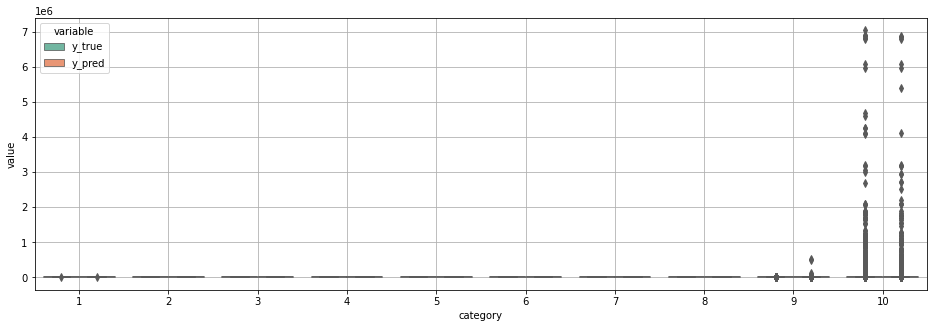

Bin  1: MAE =    0.02
Bin  2: MAE =    0.00
Bin  3: MAE =    0.00
Bin  4: MAE =    0.00
Bin  5: MAE =    0.00
Bin  6: MAE =    0.00
Bin  7: MAE =    0.00
Bin  8: MAE =    0.00
Bin  9: MAE =   59.79
Bin 10: MAE = 2892.60


In [13]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_train_val.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_train_val['category'].unique()):
    bin_filt = df_tmp_train_val['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_train_val['y_true'][bin_filt], 
                                  df_tmp_train_val['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

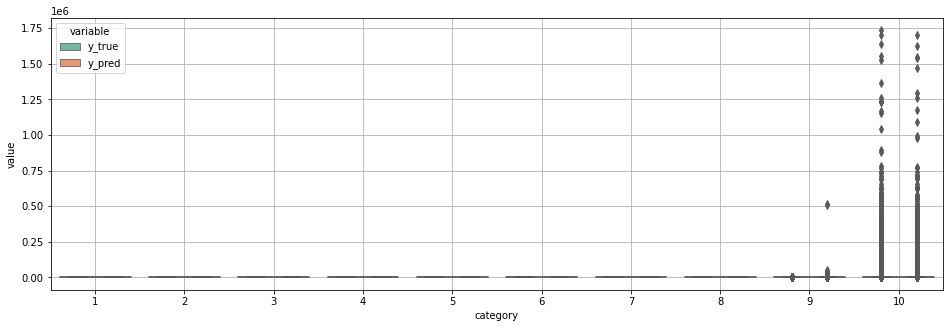

Bin  1: MAE =    0.00
Bin  2: MAE =    0.00
Bin  3: MAE =    0.00
Bin  4: MAE =    0.00
Bin  5: MAE =    0.00
Bin  6: MAE =    0.00
Bin  7: MAE =    0.00
Bin  8: MAE =    0.00
Bin  9: MAE =   89.54
Bin 10: MAE = 2197.24


In [14]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_test.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_test['category'].unique()):
    bin_filt = df_tmp_test['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_test['y_true'][bin_filt], 
                                  df_tmp_test['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

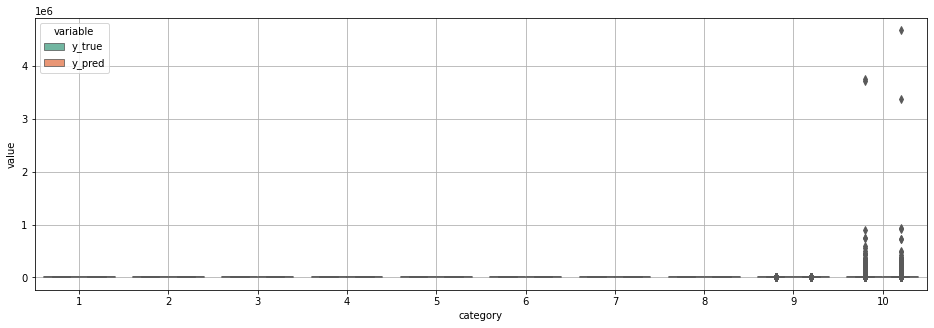

Bin  1: MAE =    0.00
Bin  2: MAE =    0.00
Bin  3: MAE =    0.00
Bin  4: MAE =    0.00
Bin  5: MAE =    0.00
Bin  6: MAE =    0.00
Bin  7: MAE =    0.00
Bin  8: MAE =    0.00
Bin  9: MAE =   27.78
Bin 10: MAE = 1498.36


In [15]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_oot.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_oot['category'].unique()):
    bin_filt = df_tmp_oot['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_oot['y_true'][bin_filt], 
                                  df_tmp_oot['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

# Fined model

In [16]:
def mod_predict(model, X):
    return np.maximum(model.predict(X), 0)

### Linear Regression

In [17]:
def VIF_ya(data, fast_max_border=1e15):
    data = data.copy()
    res = pd.DataFrame(index=data.columns)
    curr_colnames = data.columns.tolist()
    stop_condition = False
    iter_num = 0
    
    while not stop_condition:
        iter_num += 1

        mem = []
        for ii, colname in tqdm(enumerate(curr_colnames), total=len(curr_colnames)):
            break_flag = False
            vif = variance_inflation_factor(data.values, ii)
            if (vif>fast_max_border) & (iter_num>1):
                tmp_res = res.iloc[:,-1:]
                last_col = tmp_res.columns[0]
                for mem_item in mem:
                    tmp_res.loc[mem_item[0],last_col] = mem_item[1]
                tmp_res.loc[colname,last_col] = np.nan
                break_flag = True
                break
            mem.append([colname, round(vif, 2)])
        
        if break_flag:
            tmp_res.columns = [f'VIF_{iter_num}']
        else:
            tmp_res = pd.DataFrame(mem, columns=['index', f'VIF_{iter_num}']).set_index('index')
        res = res.join(tmp_res)
        
        clear_output()
        MAX_VIF = res.iloc[:,-1].max()
        print(f'iter {iter_num}. - max VIF: {MAX_VIF}')
        curr_colnames = res.dropna().index.tolist()
        curr_colnames.remove(res.dropna().iloc[:,-1].idxmax())
        data = data[curr_colnames]
        
#         display(res)
        
        if (MAX_VIF <= 10):
            stop_condition = True
    
    return res

In [18]:
if False:
    tbl = VIF_ya(X_train_val.sample(25000, random_state=21).fillna(0))
    vif_filtered_feats = tbl.dropna().index.tolist()
else:
    vif_filtered_feats = [
     'sku_lazy', 'prev_14d_cons', 'sku_name_is_marketplace_windows_cpu_c100', 'vm_memory_min', 
        'crm_partner_manager', 'sku_subservice_is_mysql', 'billing_account_is_isv', 'vm_cores_min', 
        'sku_name_is_mdb_cluster_network_nvme_mysql', 'sku_service_is_monitoring', 
        'sku_name_is_network_public_fips_deallocated', 'billing_account_is_var', 'sku_subservice_is_speech', 
        'sku_subservice_is_redis', 'vm_memory_avg', 'sku_subservice_is_mongo', 'sku_service_is_mk8s', 
        'vm_count', 'crm_segment', 'vm_age_days_min', 'vm_gpus_max', 'vm_gpus_sum', 'vm_age_days_max', 
        'vm_cores_sum', 'sku_name_is_compute_vm_cpu_c05_v2', 'sku_name_is_marketplace_windows_cpu_c05', 
        'sku_service_is_ymq', 'sku_name_is_compute_vm_cpu_50_v2', 'sku_name_is_mdb_cluster_pg_v2_ram', 
        'sku_name_is_storage_bucket_used_space_standard', 'sku_service_is_cr', 'billing_account_state', 
        'sku_service_is_api_gateway', 'sku_name_is_compute_vm_cpu_c20_v2', 'sku_name_is_compute_vm_cpu_c100', 
        'sku_name_is_network_ingress_inet_antiddos_qrator', 'sku_subservice_is_nbs_hdd', 
        'sku_name_is_mdb_cluster_network_nvme_pg', 'sku_subservice_is_nlb', 
        'sku_name_is_support_standard_fixed_consumption_v1', 'sku_name_is_compute_vm_cpu_c05', 
        'sku_service_is_iot', 'sku_service_is_marketplace', 'billing_account_usage_status', 
        'sku_name_is_storage_api_put_standard', 'sku_name_is_compute_image', 'days_not_used', 
        'sku_name_is_storage_api_head_standard', 'billing_account_is_crm_account', 
        'sku_name_is_compute_snapshot', 'sku_name_is_compute_vm_ram_preemptible_v2', 'vm_memory_max', 
        'vm_gpus_min', 'sku_name_is_storage_api_network_inet_egress', 'sku_service_is_kms', 
        'billing_account_person_type', 'sku_service_is_ydb', 'br_week_day', 'billing_account_currency', 
        'sku_name_is_storage_api_put_cold', 'sku_subservice_name_is_other', 'sku_subservice_is_clickhouse'
   ]

In [19]:
vif_filtered_feats

['sku_lazy',
 'prev_14d_cons',
 'sku_name_is_marketplace_windows_cpu_c100',
 'vm_memory_min',
 'crm_partner_manager',
 'sku_subservice_is_mysql',
 'billing_account_is_isv',
 'vm_cores_min',
 'sku_name_is_mdb_cluster_network_nvme_mysql',
 'sku_service_is_monitoring',
 'sku_name_is_network_public_fips_deallocated',
 'billing_account_is_var',
 'sku_subservice_is_speech',
 'sku_subservice_is_redis',
 'vm_memory_avg',
 'sku_subservice_is_mongo',
 'sku_service_is_mk8s',
 'vm_count',
 'crm_segment',
 'vm_age_days_min',
 'vm_gpus_max',
 'vm_gpus_sum',
 'vm_age_days_max',
 'vm_cores_sum',
 'sku_name_is_compute_vm_cpu_c05_v2',
 'sku_name_is_marketplace_windows_cpu_c05',
 'sku_service_is_ymq',
 'sku_name_is_compute_vm_cpu_50_v2',
 'sku_name_is_mdb_cluster_pg_v2_ram',
 'sku_name_is_storage_bucket_used_space_standard',
 'sku_service_is_cr',
 'billing_account_state',
 'sku_service_is_api_gateway',
 'sku_name_is_compute_vm_cpu_c20_v2',
 'sku_name_is_compute_vm_cpu_c100',
 'sku_name_is_network_ingress

In [20]:
all_cols = vif_filtered_feats.copy()
selected_cols = []
cycle_score = -np.inf
best_score = -1
while best_score>cycle_score:
    cycle_score = best_score
    best_score = -np.inf
    best_col = None
    for col in tqdm(all_cols):
        temp_cols = selected_cols + [col]
        score = LinearRegression().fit(X_tr[temp_cols].fillna(0), y_tr).score(X_te[temp_cols].fillna(0), y_te)
        if (score > best_score):
            best_score = score
            best_col = col
    
    print(best_col, '-', best_score)
    selected_cols.append(best_col)
    all_cols.remove(best_col)
    
reg = LinearRegression().fit(X_tr[selected_cols].fillna(0), y_tr)

  0%|          | 0/62 [00:00<?, ?it/s]

prev_14d_cons - 0.560842972739744


  0%|          | 0/61 [00:00<?, ?it/s]

sku_subservice_is_redis - 0.6459576705306562


  0%|          | 0/60 [00:00<?, ?it/s]

crm_segment - 0.6549765213849064


  0%|          | 0/59 [00:00<?, ?it/s]

sku_name_is_mdb_cluster_network_nvme_mysql - 0.6638428432983801


  0%|          | 0/58 [00:00<?, ?it/s]

sku_name_is_storage_api_put_cold - 0.6707043140071406


  0%|          | 0/57 [00:00<?, ?it/s]

sku_name_is_marketplace_windows_cpu_c100 - 0.6756653912110175


  0%|          | 0/56 [00:00<?, ?it/s]

sku_subservice_is_speech - 0.6801663665433988


  0%|          | 0/55 [00:00<?, ?it/s]

sku_subservice_name_is_other - 0.6829770226647048


  0%|          | 0/54 [00:00<?, ?it/s]

vm_gpus_max - 0.6840020265725031


  0%|          | 0/53 [00:00<?, ?it/s]

vm_gpus_min - 0.6849876805740551


  0%|          | 0/52 [00:00<?, ?it/s]

vm_gpus_sum - 0.6859154149532756


  0%|          | 0/51 [00:00<?, ?it/s]

sku_subservice_is_mongo - 0.6866827393764174


  0%|          | 0/50 [00:00<?, ?it/s]

billing_account_state - 0.6873741986503225


  0%|          | 0/49 [00:00<?, ?it/s]

sku_name_is_mdb_cluster_network_nvme_pg - 0.6879111901304353


  0%|          | 0/48 [00:00<?, ?it/s]

sku_name_is_compute_vm_cpu_50_v2 - 0.6882560889833809


  0%|          | 0/47 [00:00<?, ?it/s]

sku_lazy - 0.6885037381528029


  0%|          | 0/46 [00:00<?, ?it/s]

sku_name_is_compute_vm_cpu_c05_v2 - 0.688686421402761


  0%|          | 0/45 [00:00<?, ?it/s]

vm_age_days_max - 0.6888169646793811


  0%|          | 0/44 [00:00<?, ?it/s]

vm_age_days_min - 0.6895032267538678


  0%|          | 0/43 [00:00<?, ?it/s]

billing_account_usage_status - 0.6896638757739426


  0%|          | 0/42 [00:00<?, ?it/s]

billing_account_is_crm_account - 0.6897356888012689


  0%|          | 0/41 [00:00<?, ?it/s]

sku_service_is_ymq - 0.6897746172021091


  0%|          | 0/40 [00:00<?, ?it/s]

billing_account_is_isv - 0.6898051648054803


  0%|          | 0/39 [00:00<?, ?it/s]

billing_account_is_var - 0.689825921377041


  0%|          | 0/38 [00:00<?, ?it/s]

sku_service_is_iot - 0.6898409368781335


  0%|          | 0/37 [00:00<?, ?it/s]

sku_name_is_marketplace_windows_cpu_c05 - 0.689848151865498


  0%|          | 0/36 [00:00<?, ?it/s]

days_not_used - 0.6898484282956152


  0%|          | 0/35 [00:00<?, ?it/s]

sku_service_is_api_gateway - 0.68984840864033


In [21]:
reg = LinearRegression().fit(X_tr[selected_cols].fillna(0), y_tr)

In [22]:
shift_r = np.median(reg.predict(X_train_val[selected_cols].fillna(0)))  # reg.predict(X_train_val[selected_cols].fillna(0)).min()

df_tmp_train_val = pd.DataFrame({
    'y_true': y_train_val.values.ravel(),
    'y_pred': mod_predict(reg, X_train_val[selected_cols].fillna(0))-shift_r,
})

df_tmp_test = pd.DataFrame({
    'y_true': y_test.values.ravel(),
    'y_pred': mod_predict(reg, X_test[selected_cols].fillna(0))-shift_r,
})

df_tmp_oot = pd.DataFrame({
    'y_true': y_oot.values.ravel(),
    'y_pred': mod_predict(reg, X_oot[selected_cols].fillna(0))-shift_r,
})

df_tmp_train_val = df_tmp_train_val.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_test = df_tmp_test.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_oot = df_tmp_oot.sort_values(['y_true', 'y_pred']).reset_index(drop=True)

df_tmp_train_val['category'] = pd.qcut(df_tmp_train_val.index, q=10, labels=False)+1
df_tmp_test['category'] = pd.qcut(df_tmp_test.index, q=10, labels=False)+1
df_tmp_oot['category'] = pd.qcut(df_tmp_oot.index, q=10, labels=False)+1

In [23]:
# reg = ElasticNet(alpha=0, l1_ratio=0.5, random_state=0, normalize=True)
# reg.fit(X_tr[vif_filtered_feats].fillna(0), y_tr)

# reg.score(X_tr[vif_filtered_feats].fillna(0), y_tr)

In [24]:
# df_tmp_train_val = pd.DataFrame({
#     'y_true': y_train_val.values.ravel(),
#     'y_pred': mod_predict(reg, X_train_val[vif_filtered_feats].fillna(0)),
# })

# df_tmp_test = pd.DataFrame({
#     'y_true': y_test.values.ravel(),
#     'y_pred': mod_predict(reg, X_test[vif_filtered_feats].fillna(0)),
# })

# df_tmp_oot = pd.DataFrame({
#     'y_true': y_oot.values.ravel(),
#     'y_pred': mod_predict(reg, X_oot[vif_filtered_feats].fillna(0)),
# })

# df_tmp_train_val = df_tmp_train_val.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
# df_tmp_test = df_tmp_test.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
# df_tmp_oot = df_tmp_oot.sort_values(['y_true', 'y_pred']).reset_index(drop=True)

# df_tmp_train_val['category'] = pd.qcut(df_tmp_train_val.index, q=10, labels=False)+1
# df_tmp_test['category'] = pd.qcut(df_tmp_test.index, q=10, labels=False)+1
# df_tmp_oot['category'] = pd.qcut(df_tmp_oot.index, q=10, labels=False)+1

In [25]:
RMSE_train = np.sqrt(mean_squared_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred']))
print('RMSE on train:         %15.4f' % RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(df_tmp_test['y_true'], df_tmp_test['y_pred']))
print('RMSE on test:          %15.4f' % RMSE_test)

RMSE_oot = np.sqrt(mean_squared_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred']))
print('RMSE on oot-sample:    %15.4f' % RMSE_oot)

print('Time stability delta: %15.4f' % (RMSE_test - RMSE_oot))

RMSE on train:              15031.0824
RMSE on test:                7060.1883
RMSE on oot-sample:          5218.8447
Time stability delta:       1841.3436


In [26]:
MAE_train = mean_absolute_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAE on train:         %15.4f' % MAE_train)

MAE_test = mean_absolute_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAE on test:          %15.4f' % MAE_test)

MAE_oot = mean_absolute_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAE on oot-sample:    %15.4f' % MAE_oot)

print('Time stability delta: %15.4f' % (MAE_test - MAE_oot))

MAE on train:                551.7233
MAE on test:                 502.7866
MAE on oot-sample:           451.3938
Time stability delta:         51.3927


In [27]:
MAPE_train = mean_absolute_percentage_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAPE on train:         %10.7f' % MAPE_train)

MAPE_test = mean_absolute_percentage_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAPE on test:          %10.7f' % MAPE_test)

MAPE_oot = mean_absolute_percentage_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAPE on oot-sample:    %10.7f' % MAPE_oot)

print('Time stability delta:  %10.7f' % (MAPE_test - MAPE_oot))

MAPE on train:          0.0001237
MAPE on test:           0.0003106
MAPE on oot-sample:     0.0010982
Time stability delta:  -0.0007876


In [28]:
R_squared_train = r2_score(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('R_squared on train:       %15.4f' % R_squared_train)

R_squared_test = r2_score(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('R_squared on test:        %15.4f' % R_squared_test)

R_squared_oot = r2_score(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('R_squared on oot-sample:  %15.4f' % R_squared_oot)

print('Time stability delta:     %15.4f' % (R_squared_test - R_squared_oot))

R_squared on train:                0.8323
R_squared on test:                 0.8245
R_squared on oot-sample:           0.9568
Time stability delta:             -0.1323


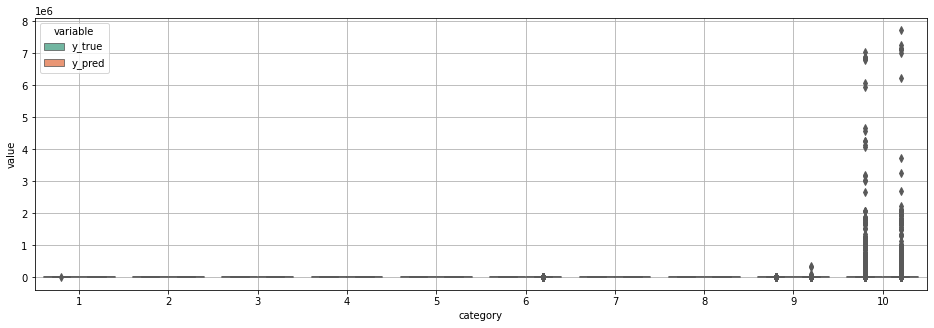

Bin  1: MAE =    7.88
Bin  2: MAE =    7.87
Bin  3: MAE =    7.87
Bin  4: MAE =    7.87
Bin  5: MAE =    7.87
Bin  6: MAE =    7.87
Bin  7: MAE =   10.89
Bin  8: MAE =   16.87
Bin  9: MAE =  515.91
Bin 10: MAE = 4926.33


In [29]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_train_val.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_train_val['category'].unique()):
    bin_filt = df_tmp_train_val['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_train_val['y_true'][bin_filt], 
                                  df_tmp_train_val['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

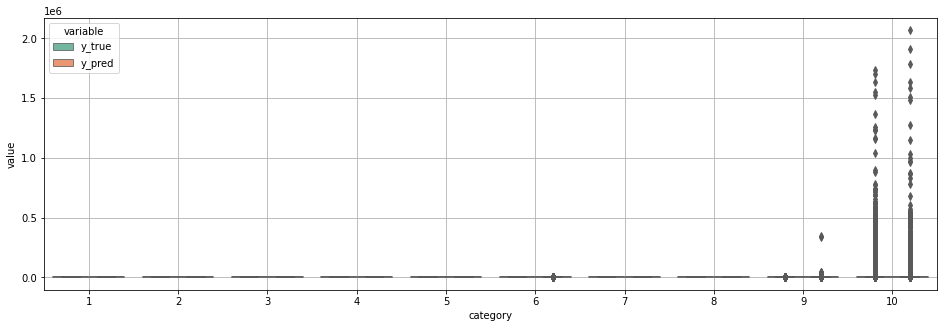

Bin  1: MAE =    7.87
Bin  2: MAE =    7.87
Bin  3: MAE =    7.87
Bin  4: MAE =    7.87
Bin  5: MAE =    7.87
Bin  6: MAE =    7.88
Bin  7: MAE =   11.01
Bin  8: MAE =   17.00
Bin  9: MAE =  571.83
Bin 10: MAE = 4380.72


In [30]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_test.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_test['category'].unique()):
    bin_filt = df_tmp_test['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_test['y_true'][bin_filt], 
                                  df_tmp_test['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

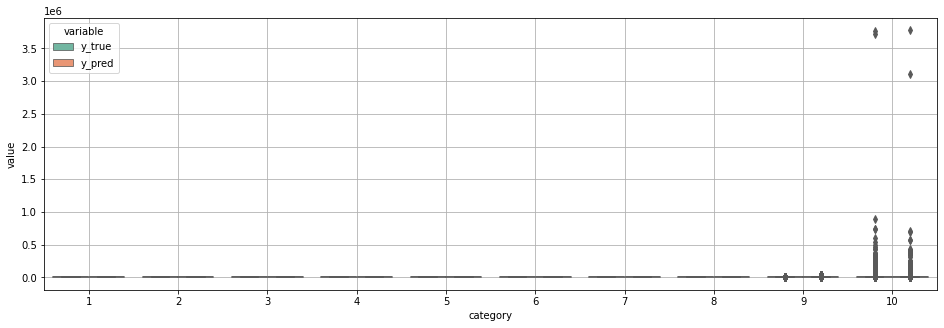

Bin  1: MAE =    7.87
Bin  2: MAE =   18.75
Bin  3: MAE =   25.33
Bin  4: MAE =   26.93
Bin  5: MAE =   28.55
Bin  6: MAE =   30.17
Bin  7: MAE =   31.80
Bin  8: MAE =   33.46
Bin  9: MAE =  541.52
Bin 10: MAE = 3769.50


In [31]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_oot.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_oot['category'].unique()):
    bin_filt = df_tmp_oot['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_oot['y_true'][bin_filt], 
                                  df_tmp_oot['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

In [32]:
# cvt = IdsTimeCV(id_train_val, time_split_num=3, random_state=21)

In [33]:
# parameters = {
#     'alpha': np.arange(10,11,1)
# }

# reg_par = ElasticNet(max_iter=100)
# clf = GridSearchCV(reg_par, parameters, cv=cvt, verbose=3)
# clf.fit(X_train_val[vif_filtered_feats].fillna(0), y_train_val)

# sorted(clf.cv_results_.keys())

In [34]:
# reg_par_tr = clf.best_estimator_

In [35]:
# df_tmp_train_val = pd.DataFrame({
#     'y_true': y_train_val.values.ravel(),
#     'y_pred': mod_predict(reg_par_tr, X_train_val[vif_filtered_feats].fillna(0)),
# })

# df_tmp_test = pd.DataFrame({
#     'y_true': y_test.values.ravel(),
#     'y_pred': mod_predict(reg_par_tr, X_test[vif_filtered_feats].fillna(0)),
# })

# df_tmp_oot = pd.DataFrame({
#     'y_true': y_oot.values.ravel(),
#     'y_pred': mod_predict(reg_par_tr, X_oot[vif_filtered_feats].fillna(0)),
# })

# df_tmp_train_val = df_tmp_train_val.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
# df_tmp_test = df_tmp_test.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
# df_tmp_oot = df_tmp_oot.sort_values(['y_true', 'y_pred']).reset_index(drop=True)

# df_tmp_train_val['category'] = pd.qcut(df_tmp_train_val.index, q=10, labels=False)+1
# df_tmp_test['category'] = pd.qcut(df_tmp_test.index, q=10, labels=False)+1
# df_tmp_oot['category'] = pd.qcut(df_tmp_oot.index, q=10, labels=False)+1

In [36]:
# RMSE_train = np.sqrt(mean_squared_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred']))
# print('RMSE on train:         %15.4f' % RMSE_train)

# RMSE_test = np.sqrt(mean_squared_error(df_tmp_test['y_true'], df_tmp_test['y_pred']))
# print('RMSE on test:          %15.4f' % RMSE_test)

# RMSE_oot = np.sqrt(mean_squared_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred']))
# print('RMSE on oot-sample:    %15.4f' % RMSE_oot)

# print('Time stability delta: %15.4f' % (RMSE_test - RMSE_oot))

In [37]:
# MAE_train = mean_absolute_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
# print('MAE on train:         %15.4f' % MAE_train)

# MAE_test = mean_absolute_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
# print('MAE on test:          %15.4f' % MAE_test)

# MAE_oot = mean_absolute_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
# print('MAE on oot-sample:    %15.4f' % MAE_oot)

# print('Time stability delta: %15.4f' % (MAE_test - MAE_oot))

In [38]:
# MAPE_train = mean_absolute_percentage_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
# print('MAPE on train:         %10.7f' % MAPE_train)

# MAPE_test = mean_absolute_percentage_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
# print('MAPE on test:          %10.7f' % MAPE_test)

# MAPE_oot = mean_absolute_percentage_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
# print('MAPE on oot-sample:    %10.7f' % MAPE_oot)

# print('Time stability delta:  %10.7f' % (MAPE_test - MAPE_oot))

In [39]:
# R_squared_train = r2_score(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
# print('R_squared on train:       %15.4f' % R_squared_train)

# R_squared_test = r2_score(df_tmp_test['y_true'], df_tmp_test['y_pred'])
# print('R_squared on test:        %15.4f' % R_squared_test)

# R_squared_oot = r2_score(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
# print('R_squared on oot-sample:  %15.4f' % R_squared_oot)

# print('Time stability delta:     %15.4f' % (R_squared_test - R_squared_oot))

In [40]:
# plt.subplots(figsize=[16,5])
# sns.boxplot(x='category', 
#             y='value', 
#             hue='variable', 
#             data=df_tmp_train_val.melt(id_vars=['category']), 
#             palette='Set2')

# plt.grid()
# plt.show()

# for bin_num in sorted(df_tmp_train_val['category'].unique()):
#     bin_filt = df_tmp_train_val['category']==bin_num
#     bin_MAE = mean_absolute_error(df_tmp_train_val['y_true'][bin_filt], 
#                                   df_tmp_train_val['y_pred'][bin_filt])
#     print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

In [41]:
# plt.subplots(figsize=[16,5])
# sns.boxplot(x='category', 
#             y='value', 
#             hue='variable', 
#             data=df_tmp_test.melt(id_vars=['category']), 
#             palette='Set2')

# plt.grid()
# plt.show()

# for bin_num in sorted(df_tmp_test['category'].unique()):
#     bin_filt = df_tmp_test['category']==bin_num
#     bin_MAE = mean_absolute_error(df_tmp_test['y_true'][bin_filt], 
#                                   df_tmp_test['y_pred'][bin_filt])
#     print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

In [42]:
# plt.subplots(figsize=[16,5])
# sns.boxplot(x='category', 
#             y='value', 
#             hue='variable', 
#             data=df_tmp_oot.melt(id_vars=['category']), 
#             palette='Set2')

# plt.grid()
# plt.show()

# for bin_num in sorted(df_tmp_oot['category'].unique()):
#     bin_filt = df_tmp_oot['category']==bin_num
#     bin_MAE = mean_absolute_error(df_tmp_oot['y_true'][bin_filt], 
#                                   df_tmp_oot['y_pred'][bin_filt])
#     print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

### CatBoost

In [43]:
cat_base = CatBoostRegressor(iterations=500,
                             learning_rate=0.01,
                             depth=10,
                             loss_function="RMSE",
                             verbose=False)
cat_base.fit(X_tr, 
             y_tr, 
             eval_set=(X_te, y_te), 
             use_best_model=True, 
             early_stopping_rounds=30, 
             verbose=False, 
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
shift_m = 0  # cat_base.predict(X_train_val).min()

df_tmp_train_val = pd.DataFrame({
    'y_true': y_train_val.values.ravel(),
    'y_pred': mod_predict(cat_base, X_train_val)-shift_m,
})

df_tmp_test = pd.DataFrame({
    'y_true': y_test.values.ravel(),
    'y_pred': mod_predict(cat_base, X_test)-shift_m,
})

df_tmp_oot = pd.DataFrame({
    'y_true': y_oot.values.ravel(),
    'y_pred': mod_predict(cat_base, X_oot)-shift_m,
})

df_tmp_train_val = df_tmp_train_val.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_test = df_tmp_test.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_oot = df_tmp_oot.sort_values(['y_true', 'y_pred']).reset_index(drop=True)

df_tmp_train_val['category'] = pd.qcut(df_tmp_train_val.index, q=10, labels=False)+1
df_tmp_test['category'] = pd.qcut(df_tmp_test.index, q=10, labels=False)+1
df_tmp_oot['category'] = pd.qcut(df_tmp_oot.index, q=10, labels=False)+1

In [45]:
RMSE_train = np.sqrt(mean_squared_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred']))
print('RMSE on train:         %15.4f' % RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(df_tmp_test['y_true'], df_tmp_test['y_pred']))
print('RMSE on test:          %15.4f' % RMSE_test)

RMSE_oot = np.sqrt(mean_squared_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred']))
print('RMSE on oot-sample:    %15.4f' % RMSE_oot)

print('Time stability delta: %15.4f' % (RMSE_test - RMSE_oot))

RMSE on train:              13518.6722
RMSE on test:                4555.0369
RMSE on oot-sample:         10730.5058
Time stability delta:      -6175.4689


In [46]:
MAE_train = mean_absolute_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAE on train:         %15.4f' % MAE_train)

MAE_test = mean_absolute_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAE on test:          %15.4f' % MAE_test)

MAE_oot = mean_absolute_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAE on oot-sample:    %15.4f' % MAE_oot)

print('Time stability delta: %15.4f' % (MAE_test - MAE_oot))

MAE on train:                268.5146
MAE on test:                 229.3340
MAE on oot-sample:           284.7723
Time stability delta:        -55.4383


In [47]:
MAPE_train = mean_absolute_percentage_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAPE on train:         %10.7f' % MAPE_train)

MAPE_test = mean_absolute_percentage_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAPE on test:          %10.7f' % MAPE_test)

MAPE_oot = mean_absolute_percentage_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAPE on oot-sample:    %10.7f' % MAPE_oot)

print('Time stability delta:  %10.7f' % (MAPE_test - MAPE_oot))

MAPE on train:          0.0000602
MAPE on test:           0.0001417
MAPE on oot-sample:     0.0006928
Time stability delta:  -0.0005511


In [48]:
R_squared_train = r2_score(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('R_squared on train:       %15.4f' % R_squared_train)

R_squared_test = r2_score(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('R_squared on test:        %15.4f' % R_squared_test)

R_squared_oot = r2_score(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('R_squared on oot-sample:  %15.4f' % R_squared_oot)

print('Time stability delta:     %15.4f' % (R_squared_test - R_squared_oot))

R_squared on train:                0.8644
R_squared on test:                 0.9269
R_squared on oot-sample:           0.8174
Time stability delta:              0.1096


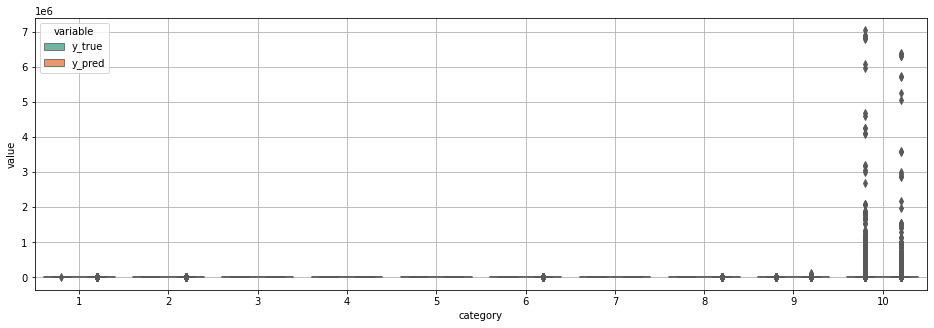

Bin  1: MAE =    8.26
Bin  2: MAE =    8.70
Bin  3: MAE =    8.75
Bin  4: MAE =    8.99
Bin  5: MAE =    9.17
Bin  6: MAE =    9.37
Bin  7: MAE =    9.57
Bin  8: MAE =   11.17
Bin  9: MAE =  156.59
Bin 10: MAE = 2454.56


In [49]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_train_val.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_train_val['category'].unique()):
    bin_filt = df_tmp_train_val['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_train_val['y_true'][bin_filt], 
                                  df_tmp_train_val['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

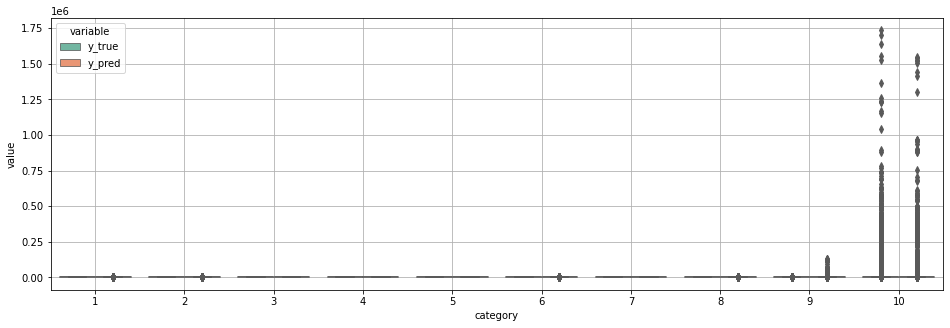

Bin  1: MAE =    8.23
Bin  2: MAE =    8.70
Bin  3: MAE =    8.76
Bin  4: MAE =    8.99
Bin  5: MAE =    9.17
Bin  6: MAE =    9.37
Bin  7: MAE =    9.57
Bin  8: MAE =   11.32
Bin  9: MAE =  238.27
Bin 10: MAE = 1980.93


In [50]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_test.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_test['category'].unique()):
    bin_filt = df_tmp_test['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_test['y_true'][bin_filt], 
                                  df_tmp_test['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

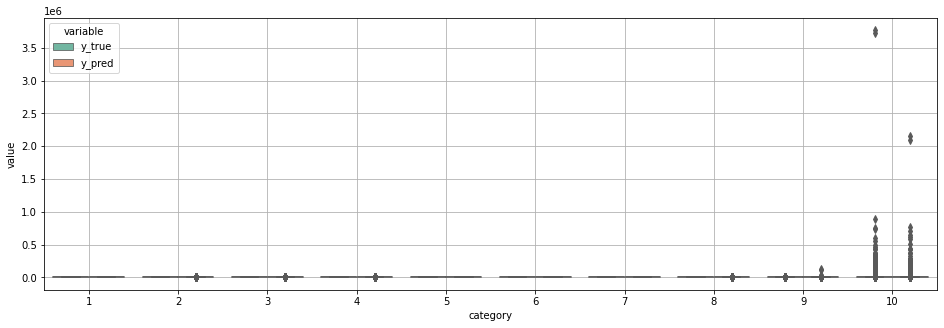

Bin  1: MAE =    8.15
Bin  2: MAE =    8.16
Bin  3: MAE =    8.56
Bin  4: MAE =    8.77
Bin  5: MAE =    8.80
Bin  6: MAE =    9.03
Bin  7: MAE =    9.16
Bin  8: MAE =   13.44
Bin  9: MAE =  244.68
Bin 10: MAE = 2528.92


In [51]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_oot.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_oot['category'].unique()):
    bin_filt = df_tmp_oot['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_oot['y_true'][bin_filt], 
                                  df_tmp_oot['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

#### Feature selection

In [52]:
# cat_t = CatBoostRegressor(iterations=500,
#                           learning_rate=0.01,
#                           max_depth=10,
#                           loss_function="RMSE",
#                           verbose=False)

# summary = cat_t.select_features(
#     X_tr, 
#     y_tr, 
#     eval_set=(X_te, y_te), 
#     features_for_select='0-122',
#     num_features_to_select=40,
#     steps=10,
#     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
#     shap_calc_type=EShapCalcType.Regular,
#     train_final_model=True,
#     logging_level='Silent',
#     plot=True
# )


In [53]:
# sel_feats = summary['selected_features_names']

In [54]:
# cat_feats = CatBoostRegressor(iterations=1000,
#                         learning_rate=0.01,
#                         max_depth=10,
#                         loss_function="RMSE",
#                         verbose=False)
# cat_feats.fit(X_tr[sel_feats], 
#         y_tr, 
#         eval_set=(X_te[sel_feats], y_te), 
#         use_best_model=True, 
#         early_stopping_rounds=100, 
#         verbose=False, 
#         plot=True)

In [55]:
# RMSE_train = np.sqrt(mean_squared_error(y_train_val, mod_predict(cat_feats, X_train_val[sel_feats])))
# print('RMSE on train:         %15.4f' % RMSE_train)

# RMSE_test = np.sqrt(mean_squared_error(y_test, mod_predict(cat_feats, X_test[sel_feats])))
# print('RMSE on test:          %15.4f' % RMSE_test)

# RMSE_oot = np.sqrt(mean_squared_error(y_oot, mod_predict(cat_feats, X_oot[sel_feats])))
# print('RMSE on oot-sample:    %15.4f' % RMSE_oot)

# print('Time stability delta: %15.4f' % (RMSE_test - RMSE_oot))

In [56]:
# MAE_train = mean_absolute_error(y_train_val, mod_predict(cat_feats, X_train_val[sel_feats]))
# print('MAE on train:         %15.4f' % MAE_train)

# MAE_test = mean_absolute_error(y_test, mod_predict(cat_feats, X_test[sel_feats]))
# print('MAE on test:          %15.4f' % MAE_test)

# MAE_oot = mean_absolute_error(y_oot, mod_predict(cat_feats, X_oot[sel_feats]))
# print('MAE on oot-sample:    %15.4f' % MAE_oot)

# print('Time stability delta: %15.4f' % (MAE_test - MAE_oot))

In [57]:
# MAPE_train = mean_absolute_percentage_error(y_train_val, mod_predict(cat_feats, X_train_val[sel_feats]))
# print('MAPE on train:         %10.7f' % MAPE_train)

# MAPE_test = mean_absolute_percentage_error(y_test, mod_predict(cat_feats, X_test[sel_feats]))
# print('MAPE on test:          %10.7f' % MAPE_test)

# MAPE_oot = mean_absolute_percentage_error(y_oot, mod_predict(cat_feats, X_oot[sel_feats]))
# print('MAPE on oot-sample:    %10.7f' % MAPE_oot)

# print('Time stability delta:  %10.7f' % (MAPE_test - MAPE_oot))

In [58]:
# R_squared_train = r2_score(y_train_val, mod_predict(cat_feats, X_train_val[sel_feats]))
# print('R_squared on train:       %15.4f' % R_squared_train)

# R_squared_test = r2_score(y_test, mod_predict(cat_feats, X_test[sel_feats]))
# print('R_squared on test:        %15.4f' % R_squared_test)

# R_squared_oot = r2_score(y_oot, mod_predict(cat_feats, X_oot[sel_feats]))
# print('R_squared on oot-sample:  %15.4f' % R_squared_oot)

# print('Time stability delta:     %15.4f' % (R_squared_test - R_squared_oot))

#### Search of hyperparams

In [59]:
# cvt = IdsTimeCV(id_train_val, random_state=21)

In [60]:
# params = {"iterations": 500,
#           "learning_rate": 0.01,
#           "max_depth": 10,
#           "loss_function": "RMSE",
# #           "per_float_feature_quantization": f'{golden_feature_num}:border_count=1024',
#           "verbose": False}
# cv_dataset = Pool(data=X_train_val[sel_feats],
#                   label=y_train_val)
# scores = cv(cv_dataset,
#             params,
#             folds=cvt, 
#             shuffle=False, 
#             plot="True")

In [61]:
# cat_par = CatBoostRegressor(iterations=100,
#                             learning_rate=0.01,
#                             loss_function="RMSE",
#                             verbose=False)

# grid = {
#     "depth": [7, 8, 9],
#     "l2_leaf_reg": [1, 2, 3, 4],
#     "random_strength": [1, 2, 3],
#     "bagging_temperature": [0, 0.5]
# }


# grid_search_result = cat_par.grid_search(grid, 
#                                          X=X_train_val[sel_feats], 
#                                          y=y_train_val, 
#                                          cv=cvt,
#                                          refit=True,
#                                          search_by_train_test_split=False,
#                                          shuffle=False,
#                                          plot=True)

# Blended model

In [62]:
class blended:
    def __init__(self, base, reg, cat, reg_feats, cat_shift, reg_shift):
        self.base = base
        self.cat = cat
        self.reg = reg
        self.reg_feats = reg_feats
        self.cat_shift = cat_shift
        self.reg_shift = reg_shift
        
    def predict(self, X):
        base_pred = pd.Series(self.base.predict(X), index=X.index).clip(lower=0)
        cat_pred = pd.Series(self.cat.predict(X)-self.cat_shift, index=X.index).clip(lower=0)
        reg_pred = pd.Series(self.reg.predict(X[self.reg_feats].fillna(0)-self.reg_shift), 
                             index=X.index).clip(lower=0)
        return (base_pred+cat_pred)/2  # (base_pred+cat_pred+reg_pred)/3

In [63]:
shift_m = 0 # cat_base.predict(X_train_val).min()
shift_r = np.median(reg.predict(X_train_val[selected_cols].fillna(0)))
blnd = blended(base, reg, cat_base, selected_cols, shift_m, shift_r)

In [64]:
df_tmp_train_val = pd.DataFrame({
    'y_true': y_train_val.values.ravel(),
    'y_pred': blnd.predict(X_train_val).values.ravel(),
})

df_tmp_test = pd.DataFrame({
    'y_true': y_test.values.ravel(),
    'y_pred': blnd.predict(X_test).values.ravel(),
})

df_tmp_oot = pd.DataFrame({
    'y_true': y_oot.values.ravel(),
    'y_pred': blnd.predict(X_oot).values.ravel(),
})

df_tmp_train_val = df_tmp_train_val.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_test = df_tmp_test.sort_values(['y_true', 'y_pred']).reset_index(drop=True)
df_tmp_oot = df_tmp_oot.sort_values(['y_true', 'y_pred']).reset_index(drop=True)

df_tmp_train_val['category'] = pd.qcut(df_tmp_train_val.index, q=10, labels=False)+1
df_tmp_test['category'] = pd.qcut(df_tmp_test.index, q=10, labels=False)+1
df_tmp_oot['category'] = pd.qcut(df_tmp_oot.index, q=10, labels=False)+1

In [65]:
RMSE_train = np.sqrt(mean_squared_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred']))
print('RMSE on train:         %15.4f' % RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(df_tmp_test['y_true'], df_tmp_test['y_pred']))
print('RMSE on test:          %15.4f' % RMSE_test)

RMSE_oot = np.sqrt(mean_squared_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred']))
print('RMSE on oot-sample:    %15.4f' % RMSE_oot)

print('Time stability delta: %15.4f' % (RMSE_test - RMSE_oot))

RMSE on train:              13652.6560
RMSE on test:                4991.3926
RMSE on oot-sample:          5659.4543
Time stability delta:       -668.0617


In [66]:
MAE_train = mean_absolute_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAE on train:         %15.4f' % MAE_train)

MAE_test = mean_absolute_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAE on test:          %15.4f' % MAE_test)

MAE_oot = mean_absolute_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAE on oot-sample:    %15.4f' % MAE_oot)

print('Time stability delta: %15.4f' % (MAE_test - MAE_oot))

MAE on train:                264.6957
MAE on test:                 211.1790
MAE on oot-sample:           188.6505
Time stability delta:         22.5285


In [67]:
MAPE_train = mean_absolute_percentage_error(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('MAPE on train:         %10.7f' % MAPE_train)

MAPE_test = mean_absolute_percentage_error(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('MAPE on test:          %10.7f' % MAPE_test)

MAPE_oot = mean_absolute_percentage_error(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('MAPE on oot-sample:    %10.7f' % MAPE_oot)

print('Time stability delta:  %10.7f' % (MAPE_test - MAPE_oot))

MAPE on train:          0.0000593
MAPE on test:           0.0001304
MAPE on oot-sample:     0.0004590
Time stability delta:  -0.0003285


In [68]:
R_squared_train = r2_score(df_tmp_train_val['y_true'], df_tmp_train_val['y_pred'])
print('R_squared on train:       %15.4f' % R_squared_train)

R_squared_test = r2_score(df_tmp_test['y_true'], df_tmp_test['y_pred'])
print('R_squared on test:        %15.4f' % R_squared_test)

R_squared_oot = r2_score(df_tmp_oot['y_true'], df_tmp_oot['y_pred'])
print('R_squared on oot-sample:  %15.4f' % R_squared_oot)

print('Time stability delta:     %15.4f' % (R_squared_test - R_squared_oot))

R_squared on train:                0.8617
R_squared on test:                 0.9123
R_squared on oot-sample:           0.9492
Time stability delta:             -0.0369


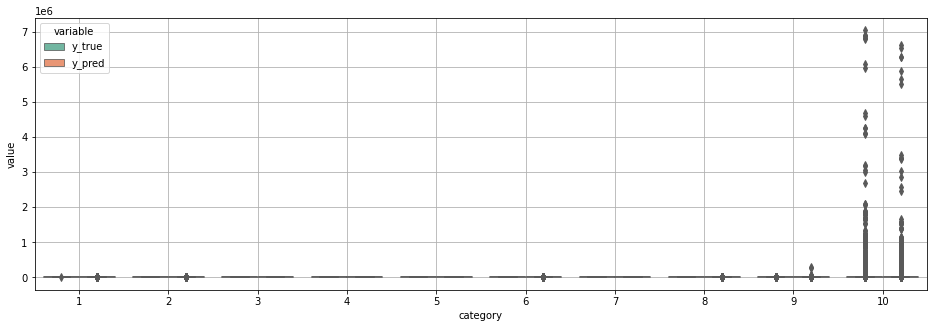

Bin  1: MAE =    4.14
Bin  2: MAE =    4.35
Bin  3: MAE =    4.38
Bin  4: MAE =    4.49
Bin  5: MAE =    4.59
Bin  6: MAE =    4.68
Bin  7: MAE =    4.79
Bin  8: MAE =    5.61
Bin  9: MAE =  108.17
Bin 10: MAE = 2501.76


In [69]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_train_val.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_train_val['category'].unique()):
    bin_filt = df_tmp_train_val['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_train_val['y_true'][bin_filt], 
                                  df_tmp_train_val['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

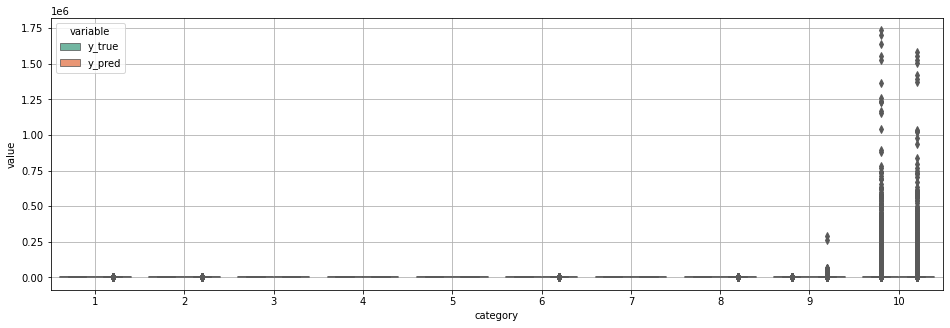

Bin  1: MAE =    4.12
Bin  2: MAE =    4.35
Bin  3: MAE =    4.38
Bin  4: MAE =    4.50
Bin  5: MAE =    4.59
Bin  6: MAE =    4.69
Bin  7: MAE =    4.79
Bin  8: MAE =    5.68
Bin  9: MAE =  163.87
Bin 10: MAE = 1910.80


In [70]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_test.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_test['category'].unique()):
    bin_filt = df_tmp_test['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_test['y_true'][bin_filt], 
                                  df_tmp_test['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

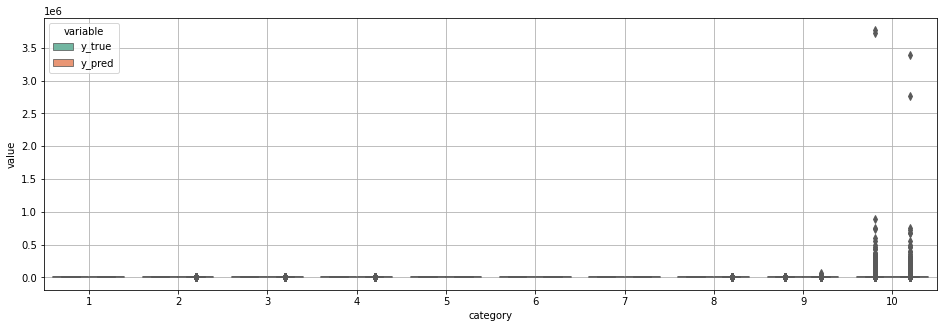

Bin  1: MAE =    4.08
Bin  2: MAE =    4.08
Bin  3: MAE =    4.28
Bin  4: MAE =    4.38
Bin  5: MAE =    4.40
Bin  6: MAE =    4.51
Bin  7: MAE =    4.58
Bin  8: MAE =    6.75
Bin  9: MAE =  136.20
Bin 10: MAE = 1713.21


In [71]:
plt.subplots(figsize=[16,5])
sns.boxplot(x='category', 
            y='value', 
            hue='variable', 
            data=df_tmp_oot.melt(id_vars=['category']), 
            palette='Set2')

plt.grid()
plt.show()

for bin_num in sorted(df_tmp_oot['category'].unique()):
    bin_filt = df_tmp_oot['category']==bin_num
    bin_MAE = mean_absolute_error(df_tmp_oot['y_true'][bin_filt], 
                                  df_tmp_oot['y_pred'][bin_filt])
    print('Bin %2d: MAE = %7.2f' % (bin_num, bin_MAE))

# Testing

In [72]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

### Analysis for Onboarding

In [73]:
shift_m = cat_base.predict(X_oot).min()
tt = pd.Series(cat_base.predict(X_oot)-shift_m, index=X_oot.index).clip(lower=0)
# tt = blnd.predict(X_oot)

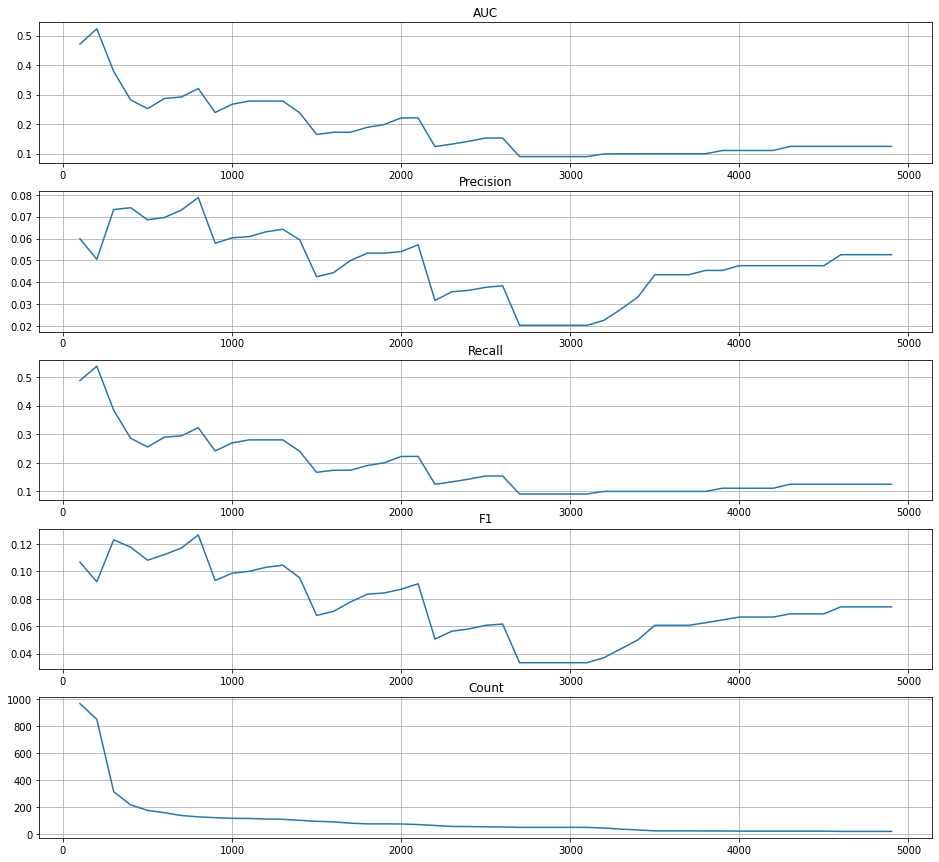

In [74]:
res = []

for lmt in np.arange(100, 5000, 100):

    tt_pred = (X_oot['prev_14d_cons']==0)*(tt>=lmt)
    tt_pred.sum()

    tt_true = (X_oot['prev_14d_cons']==0)*(y_oot>=lmt)
    tt_true.sum()

    auc_lmt = roc_auc_score(tt_true, tt_pred)*2-1
    pr_lmt = precision_score(tt_true, tt_pred)
    rec_lmt = recall_score(tt_true, tt_pred)
    f1_lmt = f1_score(tt_true, tt_pred)
    
    res.append({
        'Limit': lmt,
        'AUC': auc_lmt,
        'Precision': pr_lmt,
        'Recall': rec_lmt,
        'F1': f1_lmt,
        'Count': tt_pred.sum()
    })

res_df = pd.DataFrame(res).set_index('Limit')
fig, ax = plt.subplots(res_df.shape[1],1,figsize=(16,res_df.shape[1]*3))
for ii, col in enumerate(res_df.columns):
    ax = plt.subplot(res_df.shape[1],1,ii+1)
    plt.title(col)
    res_df[col].plot(ax=ax)
    plt.xlabel('')
    plt.grid()
plt.show()

### Analysis for CSM

In [75]:
shift_m = cat_base.predict(X_oot).min()
tt = pd.Series(cat_base.predict(X_oot)-shift_m, index=X_oot.index).clip(lower=0)
# tt = blnd.predict(X_oot)

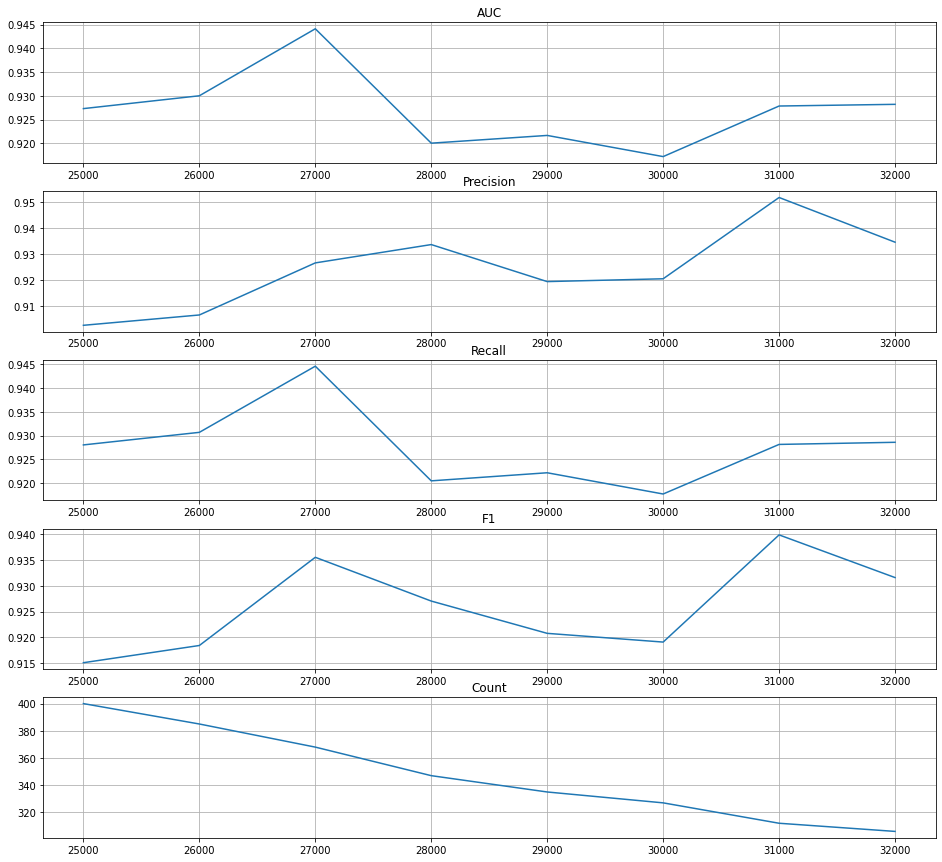

In [76]:
res = []

for lmt in np.arange(25000, 32001, 1000):

    tt_pred = ((X_oot['prev_14d_cons']+tt)>=lmt)
    tt_pred.sum()

    tt_true = ((X_oot['prev_14d_cons']+y_oot)>=lmt)
    tt_true.sum()

    auc_lmt = roc_auc_score(tt_true, tt_pred)*2-1
    pr_lmt = precision_score(tt_true, tt_pred)
    rec_lmt = recall_score(tt_true, tt_pred)
    f1_lmt = f1_score(tt_true, tt_pred)
    
    res.append({
        'Limit': lmt,
        'AUC': auc_lmt,
        'Precision': pr_lmt,
        'Recall': rec_lmt,
        'F1': f1_lmt,
        'Count': tt_pred.sum()
    })

res_df = pd.DataFrame(res).set_index('Limit')
fig, ax = plt.subplots(res_df.shape[1],1,figsize=(16,res_df.shape[1]*3))
for ii, col in enumerate(res_df.columns):
    ax = plt.subplot(res_df.shape[1],1,ii+1)
    plt.title(col)
    res_df[col].plot(ax=ax)
    plt.xlabel('')
    plt.grid()
plt.show()